In [3]:
import pandas as pd

In [4]:
def country_to_coordinates_map(csv_file):
    ''' Creates dictionary with countries as keys and
        (capital latitude, capital longitude) as values.'''
    dat = pd.read_csv(csv_file)
    coord_dict = dict()
    for index, row in dat.iterrows():
        coord_dict[row['CountryName']] = (row['CapitalLatitude'], row['CapitalLongitude'])
    return coord_dict

In [5]:
country_to_coordinates_map('country-capitals-final.csv')['Denmark']

(55.66666666666666, 12.583333)

In [6]:
from collections import defaultdict

In [7]:
def create_continent_to_countries_map(csv_file):
    '''Maps continents to countries in dataset.'''
    dat = pd.read_csv(csv_file)
    countries_from_continents_dict = defaultdict(list)
    for index, row in dat.iterrows():
        countries_from_continents_dict[row['ContinentName']].append(row['CountryName'])
    return countries_from_continents_dict

In [8]:
continent_to_countries = create_continent_to_countries_map('country-capitals-final.csv')

In [9]:
import matplotlib.pyplot as plt

In [10]:
def plot_continent_countries(dict_of_lists):
    counts = []
    for key in dict_of_lists.keys():
        counts.append(len(dict_of_lists[key]))
    plt.figure()
    plt.bar(dict_of_lists.keys(),counts,color='slateblue')

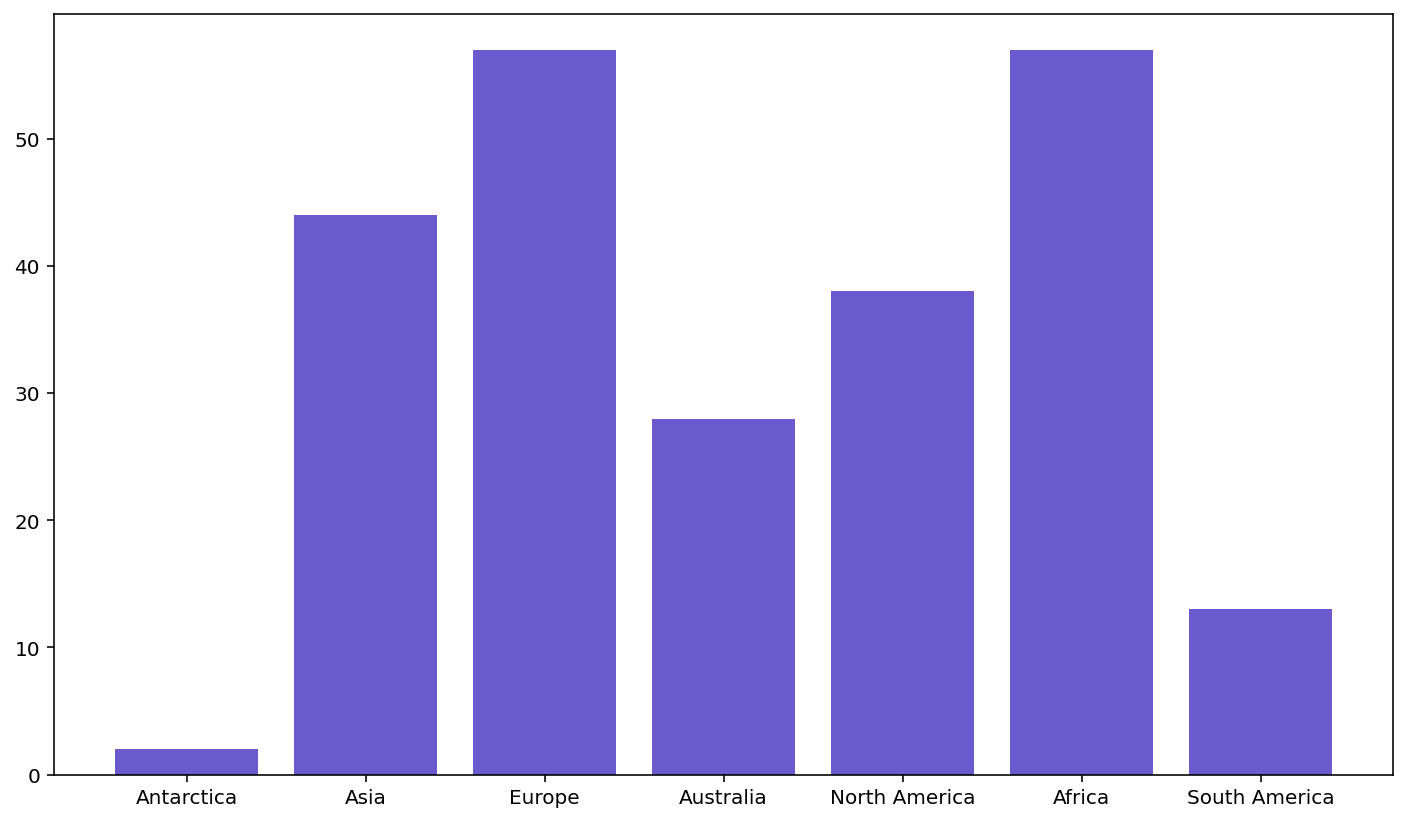

In [11]:
plot_continent_countries(continent_to_countries)

In [12]:
def read_temp_data(temp_filename):
    return pd.read_csv(temp_filename)

In [13]:
temp_dat = read_temp_data('gistemp1200_ERSSTv5.csv')

In [14]:
temp_dat_numpy = temp_dat.to_numpy()

In [17]:
import numpy as np

In [18]:
def get_domain(temp_df):
    domain_list = []
    column_names = temp_df.columns
    for column in column_names:
        get_min = np.nanmin(temp_df[column])
        get_max = np.nanmax(temp_df[column])
        get_unique = len(set([x for x in temp_df[column] if x==x]))
        domain_list.append((get_min,get_max,get_unique))
    return domain_list

In [19]:
domain = get_domain(temp_dat)

In [20]:
def get_indices(data, domain):
    """For each column in data, translate values into indices,
       using the provided domain information"""
    array = np.atleast_1d(data)
    if len(array.shape) == 1 and len(np.array(domain).shape) == 1:
        array = array.reshape(-1, 1)
        domain = [domain]
    # otherwise, interpret as a row array
    else:
        array = np.atleast_2d(array)
    # create a container for indices
    indices = np.zeros(array.shape, dtype='int')
    for j in range(array.shape[1]):
        # use the (min, max, nvalues) information provided for each column
        bins = np.linspace(domain[j][0], domain[j][1], domain[j][2])

        # the bin values refer to the center of the bin - move to refer to
        # left boundary instead
        bins += 0.5 * (bins[1] - bins[0])
        # calculate index values for all values in column
        indices[:, j] = np.digitize(array[:, j].astype('int'), bins=bins)

    # if we have a 2D array consisting of only 1 column,
    # transform to 1D
    return indices.squeeze()

In [21]:
def create_3d_array(temp_data, domain):
    # 3d array sz (n_years, n_lat, n_lon)
    n_years = domain[0][2]
    n_lat = domain[1][2]
    n_lon = domain[2][2]
    array_3d = np.empty((n_years,n_lat,n_lon))
    indices = get_indices(temp_data,domain)
    for i in range(len(temp_data)):
        array_3d[indices[i][0], indices[i][1], indices[i][2]] = temp_data[i][-1]
    return array_3d

In [22]:
array_3d = create_3d_array(temp_dat_numpy, domain)

In [23]:
def lookup_by_coordinates(array_3d, domain, lat, lon, year = True):
    if (year == True):
        n_years = domain[0][2]
        all_years = []
        for i in range(n_years):
            indices = get_indices([i, lat, lon], domain)
            all_years.append(array_3d[i,indices[1],indices[2]])
        return all_years
    indices = get_indices([year, lat, lon], domain)
    return array_3d[indices[0],indices[1],indices[2]]

In [24]:
lookup_by_coordinates(array_3d, domain, 55.66666666666666, 13, 2017)

1.5241666

In [25]:
def lookup_by_country(array_3d, domain, country_to_coord_map, country_name, year = True):
    coordinates = country_to_coord_map[country_name]
    if (year == True):
        n_years = domain[0][2]
        all_years = []
        for i in range(n_years):
            indices = get_indices([i, coordinates[0], coordinates[1]], domain)
            all_years.append(array_3d[i,indices[1],indices[2]])
        return all_years
    indices = get_indices([year, coordinates[0], coordinates[1]], domain)
    return array_3d[indices[0],indices[1],indices[2]]

In [26]:
country_to_coords = country_to_coordinates_map('country-capitals-final.csv')

In [27]:
lookup_by_country(array_3d, domain, country_to_coords, "Denmark", 2017)

1.5241666

In [28]:
class TemperatureDataFinder:
    def __init__(self, temp_file, country_capital_file):
        self.temp_file = temp_file
        self.country_capital_file = country_capital_file
        self.temp_df = read_temp_data(temp_file)
        np_array_temp = self.temp_df.to_numpy()
        self.domain = get_domain(self.temp_df)
        self.array_3d = create_3d_array(np_array_temp, self.domain)
        self.country_to_coord_map = country_to_coordinates_map(country_capital_file)

    def lookup_by_country(self,country_name, year = True):
        coordinates = self.country_to_coord_map[country_name]
        if (year == True):
            n_years = self.domain[0][2]
            all_years = []
            for i in range(n_years):
                indices = get_indices([i, coordinates[0], coordinates[1]], domain)
                all_years.append(self.array_3d[i,indices[1],indices[2]])
            return all_years
        indices = get_indices([year, coordinates[0], coordinates[1]], domain)
        return self.array_3d[indices[0],indices[1],indices[2]]

    def lookup_by_coordinates(self,lat, lon, year = True):
        if (year == True):
            n_years = self.domain[0][2]
            all_years = []
            for i in range(n_years):
                indices = get_indices([i, lat, lon], domain)
                all_years.append(array_3d[i,indices[1],indices[2]])
            return all_years
        indices = get_indices([year, lat, lon], domain)
        return self.array_3d[indices[0],indices[1],indices[2]]

In [29]:
temp_data_finder = TemperatureDataFinder('gistemp1200_ERSSTv5.csv','country-capitals-final.csv')

In [31]:
def create_country_to_index_map(continent_to_countries_dict):
    country_to_index_map = dict()
    sorted_continents = sorted(continent_to_countries.keys())
    i = 0
    for key in sorted_continents:
        sorted_countries = sorted(continent_to_countries[key])
        for value in sorted_countries:
            country_to_index_map[value] = i
            i += 1
    return country_to_index_map

In [32]:
country_axis = create_country_to_index_map(continent_to_countries)

In [33]:
def create_scatter_plot_input(temp_data_finder,country_to_index_map):
    years = list((temp_data_finder.temp_df)['year'].unique())
    country_indices = []
    temp_anomaly_vals = []
    for key in country_to_index_map.keys():
        country_indices.append(country_to_index_map[key])
        for_one_country = []
        for year in years:
            for_one_country.append(temp_data_finder.lookup_by_country(key,year))
        temp_anomaly_vals.append(for_one_country)
    temp_anoms = np.asarray(temp_anomaly_vals).transpose()
    return years, country_indices, temp_anoms

In [34]:
scatter_input = create_scatter_plot_input(temp_data_finder,country_axis)

In [0]:
def generate_ytick_inputs(continent_to_countries_map):
    sorted_continents = sorted(continent_to_countries.keys())
    yindex_placement = []
    current_i = 0
    current_cont = 0
    for key in sorted_continents:
        current_i = current_cont + int(len(continent_to_countries[key])/2)
        yindex_placement.append(current_i)
        current_cont += len(continent_to_countries[key])
    return yindex_placement, sorted_continents

In [0]:
yvals = generate_ytick_inputs(continent_to_countries)[0]
labels = generate_ytick_inputs(continent_to_countries)[1]

In [234]:
import matplotlib.lines as mlines

In [276]:
def generate_scatter_plot(years, country_indices, temp_anomaly_vals):
    fig, ax = plt.subplots()
    for i in range(len(years)):
        ax.scatter([years[i]]*len(country_indices), country_indices, c=temp_anomaly_vals[i], vmin = domain[3][0], vmax = domain[3][1] - 2*np.nanstd(temp_anomaly_vals), cmap='RdBu_r', s=5)
    plt.yticks(ticks=yvals, labels = labels)
    plt.title("Global Temperature Anomalies, 1880-2018")
    blue = mlines.Line2D([], [], color='dodgerblue', marker='.', linestyle='None',markersize=5, label='negative temperature anomalies')
    red = mlines.Line2D([], [], color='crimson', marker='.', linestyle='None',markersize=5, label='positive temperature anomalies')
    leg = ax.legend(handles=[blue,red], loc = "upper left", bbox_to_anchor=(0, 1))
    leg.get_frame().set_linewidth(0.0)

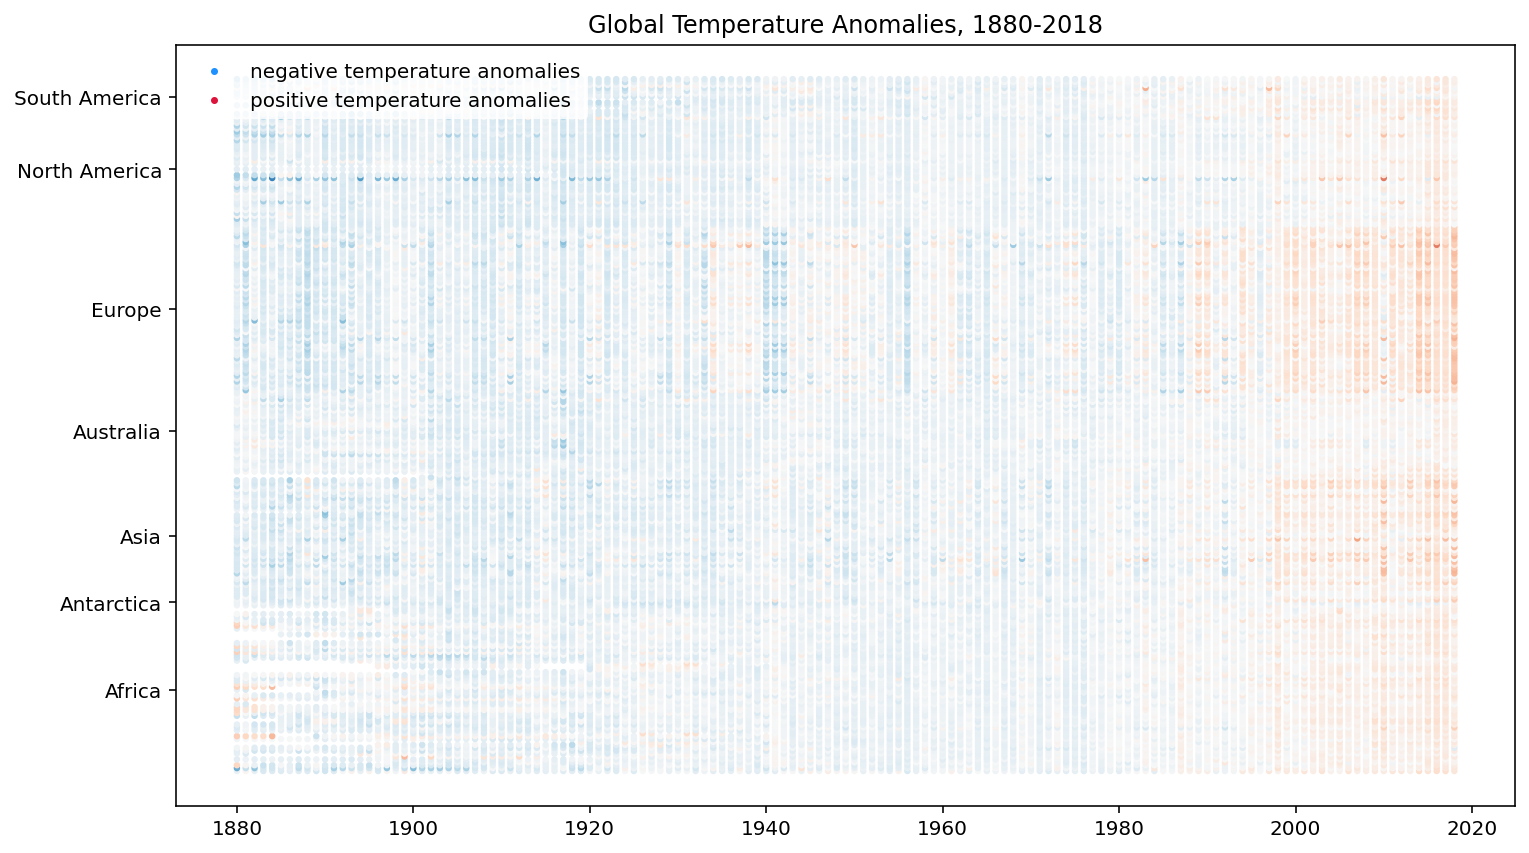

In [277]:
generate_scatter_plot(scatter_input[0],scatter_input[1],scatter_input[2])